In [1]:
import numpy as np
import pywt
import cv2
import os
import PIL
import pathlib
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn



# Preprocessing

### Testing Image Processing With Cv2

In [2]:
img = cv2.imread('test_images\Sydney-Sweeny.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape


(1000, 1500, 3)

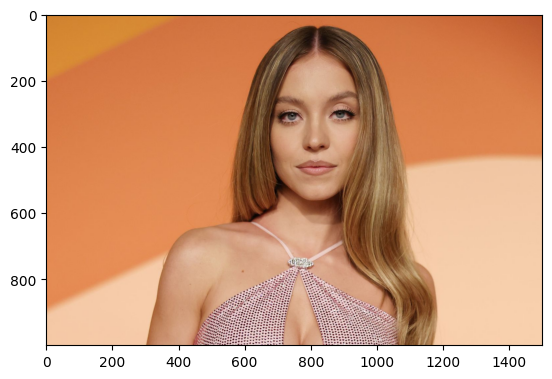

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1000, 1500)

In [5]:
gray

array([[113, 113, 114, ...,  84,  84,  84],
       [113, 113, 113, ...,  84,  84,  84],
       [112, 112, 112, ...,  84,  84,  84],
       ...,
       [195, 195, 195, ..., 201, 201, 201],
       [195, 195, 195, ..., 202, 202, 202],
       [195, 195, 195, ..., 203, 203, 203]], dtype=uint8)

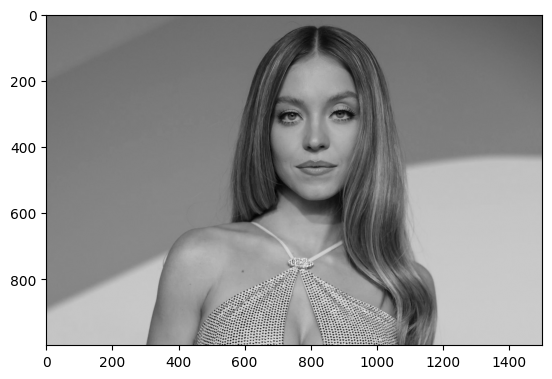

In [6]:
plt.imshow(gray , cmap='gray')

#### Detecting Face & Eyes Using Haarcascades

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[637, 167, 356, 356]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(np.int32(637), np.int32(167), np.int32(356), np.int32(356))

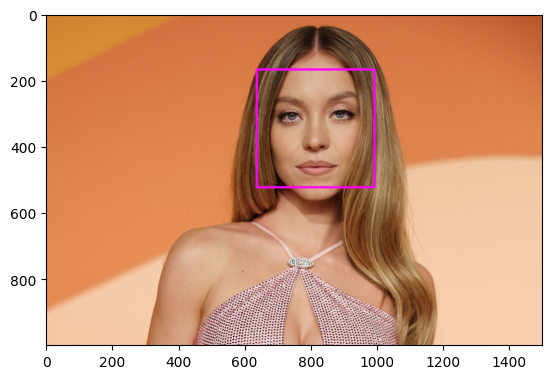

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 255),5)
plt.imshow(face_img)

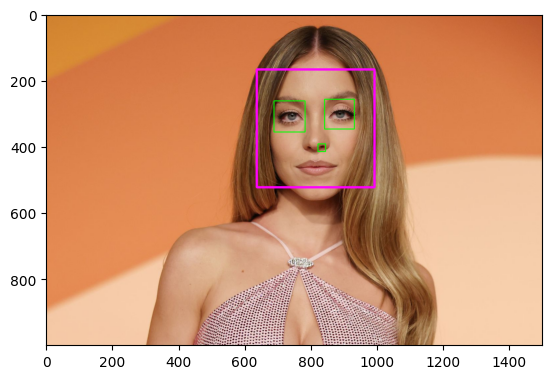

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

In [11]:
# Its considering nostrils as a Eye 
# Such Errors are coommon while using Haarcascades

### Croping the Face from the Images


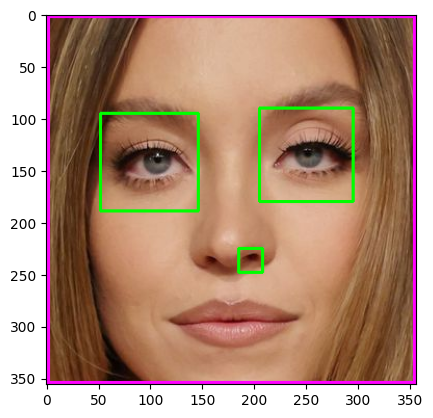

In [12]:
plt.imshow(roi_color, cmap='gray')

In [13]:
cropped_img = np.array(roi_color)
cropped_img.shape

(356, 356, 3)

In [14]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

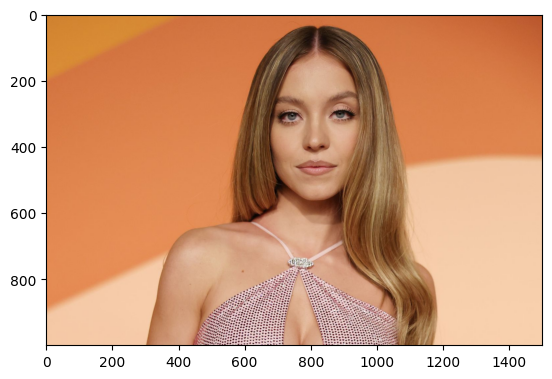

In [15]:
image = cv2.imread('test_images\Sydney-Sweeny.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

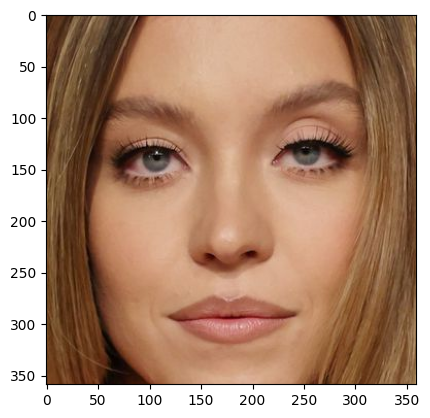

In [16]:
cropped_image = get_cropped_image_if_2_eyes('test_images\Sydney-Sweeny.jpg')
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_image)

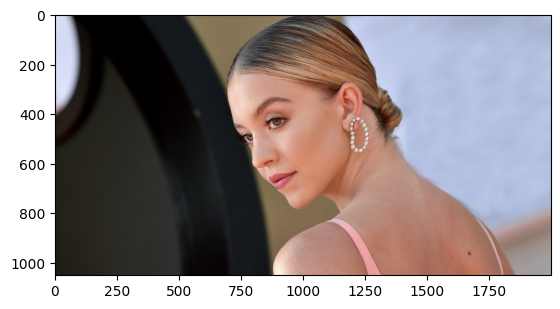

In [17]:
Wrong_image = cv2.imread('test_images\Sydney-Sweeny-Side-pro.jpg')
Wrong_image = cv2.cvtColor(Wrong_image, cv2.COLOR_BGR2RGB)
plt.imshow(Wrong_image)

In [18]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('test_images\Sydney-Sweeny-Side-pro.jpg')
cropped_image_no_2_eyes 

##### Since No features Were Detected , Above image is not suitable to use to train model so such images will not be used

### Wavelt Transformation For Feature Selrction

In [19]:
def w2d(img, mode='haar', level=1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.float32(img) / 255.0
    coeffs = pywt.wavedec2(img, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    img_reconstructed = pywt.waverec2(coeffs_H, mode)
    img_reconstructed *= 255
    return np.uint8(img_reconstructed)

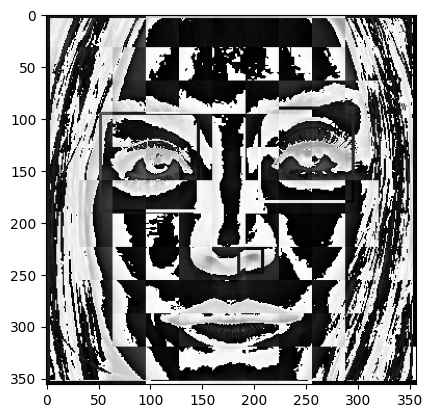

In [20]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

In [21]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [22]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [23]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [24]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        if entry.is_file():  # Only process files
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ", cropped_folder)
                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

Generating cropped images in folder:  ./dataset/cropped/Cristiano_Ronaldo
Generating cropped images in folder:  ./dataset/cropped/Kylian Mbappe
Generating cropped images in folder:  ./dataset/cropped/Lamine Yamal
Generating cropped images in folder:  ./dataset/cropped/Lionel  Messi
Generating cropped images in folder:  ./dataset/cropped/Neymar Junior


In [25]:
data_dir ='.\dataset.\cropped'
data_dir

'.\\dataset.\\cropped'

In [26]:
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('dataset./cropped')

In [27]:
player_images_dict = {
    'Cristiano_Ronaldo': list(data_dir.glob('Cristiano_Ronaldo/*')),
    'Kylian Mbappe': list(data_dir.glob('Kylian Mbappe/*')),
    'Lamine Yamal': list(data_dir.glob('Lamine Yamal/*')),
    'Lionel  Messi': list(data_dir.glob('Lionel  Messi/*')),
    'Neymar Junior': list(data_dir.glob('Neymar Junior/*')),
}

In [28]:
player_labels_dict = {
    'Cristiano_Ronaldo': 0,
    'Kylian Mbappe': 1,
    'Lamine Yamal': 2,
    'Lionel  Messi': 3,
    'Neymar Junior': 4,
}

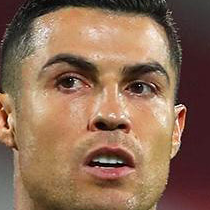

In [29]:
test_img = list(data_dir.glob('Cristiano_Ronaldo/*'))
PIL.Image.open(str(test_img[0]))

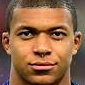

In [30]:
test_img = list(data_dir.glob('Kylian Mbappe/*'))
PIL.Image.open(str(test_img[0]))

In [31]:
player_images_dict['Cristiano_Ronaldo'][:5]

[WindowsPath('dataset./cropped/Cristiano_Ronaldo/Cristiano_Ronaldo1.png'),
 WindowsPath('dataset./cropped/Cristiano_Ronaldo/Cristiano_Ronaldo10.png'),
 WindowsPath('dataset./cropped/Cristiano_Ronaldo/Cristiano_Ronaldo11.png'),
 WindowsPath('dataset./cropped/Cristiano_Ronaldo/Cristiano_Ronaldo12.png'),
 WindowsPath('dataset./cropped/Cristiano_Ronaldo/Cristiano_Ronaldo13.png')]

In [32]:
img = cv2.imread(str(player_images_dict['Cristiano_Ronaldo'][0]))
img.shape

(210, 210, 3)

In [33]:
X, y = [], []

for player_name, images in player_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(210,210))
        X.append(resized_img)
        y.append(player_labels_dict[player_name])

In [34]:
X = np.array(X)
y = np.array(y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [36]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [37]:
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30) 

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step - accuracy: 0.2145 - loss: 2.3700
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step - accuracy: 0.2155 - loss: 1.5826
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 768ms/step - accuracy: 0.3238 - loss: 1.5538
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step - accuracy: 0.2949 - loss: 1.4724
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 611ms/step - accuracy: 0.4354 - loss: 1.3145
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step - accuracy: 0.5845 - loss: 1.1453
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step - accuracy: 0.7689 - loss: 0.8727
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.8279 - loss: 0.7047
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 581ms/step - accuracy: 0.7927 - loss: 0.6524
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.9073 - loss: 0.3538
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step - accuracy: 0.9230 - loss: 0.2399
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 637ms/step - accuracy: 0.9576 - lo

In [39]:
model.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step - accuracy: 0.7407 - loss: 1.4047


[1.404676079750061, 0.7407407164573669]

In [40]:
img_height = 210
img_width = 210

In [41]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

C:\Users\ZAIN PC\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:

model_2 = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model_2.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 667ms/step - accuracy: 0.2067 - loss: 1.8780
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step - accuracy: 0.2525 - loss: 1.6917
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - accuracy: 0.2955 - loss: 1.5853
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step - accuracy: 0.4237 - loss: 1.5643
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 704ms/step - accuracy: 0.4393 - loss: 1.5102
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step - accuracy: 0.5257 - loss: 1.4329
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 629ms/step - accuracy: 0.4622 - loss: 1.3675
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 650ms/step - accuracy: 0.4764 - loss: 1.2502
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 730ms/step - accuracy: 0.5471 - loss: 1.2334
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.5119 - loss: 1.2351
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step - accuracy: 0.6232 - loss: 1.0684
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 901ms/step - accuracy: 0.5865 - lo

In [43]:
model.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7407 - loss: 1.4047


[1.404676079750061, 0.7407407164573669]

In [54]:
model.save('model.h5')
print("✅ Model saved as model.h5")

✅ Model saved as model.h5


In [44]:
model_2.evaluate(X_test_scaled,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7037 - loss: 2.3936


[2.3936386108398438, 0.7037037014961243]

In [45]:
model_2.save('model_2.h5')
print("✅ Model saved as model_2.h5")

✅ Model saved as model_2.h5


In [46]:
predictions = model.predict(X_test_scaled)
predicted_classes = np.argmax(predictions, axis=1)
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


In [47]:
predictions_2 = model_2.predict(X_test_scaled)
predicted_classes_2 = np.argmax(predictions_2, axis=1)
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


In [48]:
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       1.00      1.00      1.00         2
           2       0.57      1.00      0.73         4
           3       0.75      0.86      0.80         7
           4       0.50      0.20      0.29         5

    accuracy                           0.74        27
   macro avg       0.74      0.77      0.73        27
weighted avg       0.74      0.74      0.72        27



In [49]:
print(classification_report(y_test, predicted_classes_2))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       1.00      1.00      1.00         2
           2       0.50      1.00      0.67         4
           3       0.80      0.57      0.67         7
           4       0.60      0.60      0.60         5

    accuracy                           0.70        27
   macro avg       0.75      0.77      0.74        27
weighted avg       0.75      0.70      0.71        27



In [50]:
cm = confusion_matrix(y_test, predicted_classes)
cm

array([[7, 0, 1, 0, 1],
       [0, 2, 0, 0, 0],
       [0, 0, 4, 0, 0],
       [0, 0, 1, 6, 0],
       [1, 0, 1, 2, 1]])

In [51]:
cm_2 = confusion_matrix(y_test, predicted_classes_2)
cm_2

array([[6, 0, 2, 0, 1],
       [0, 2, 0, 0, 0],
       [0, 0, 4, 0, 0],
       [0, 0, 2, 4, 1],
       [1, 0, 0, 1, 3]])

Text(95.72222222222221, 0.5, 'Truth')

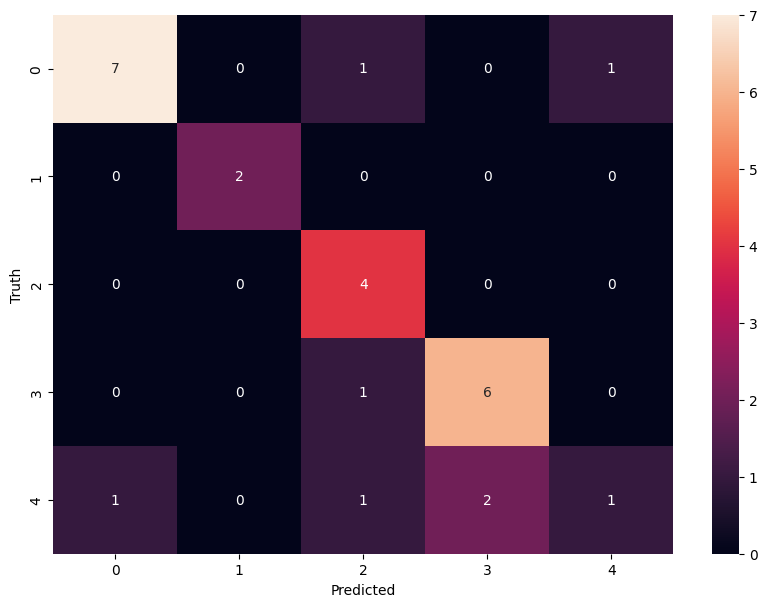

In [52]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(95.72222222222221, 0.5, 'Truth')

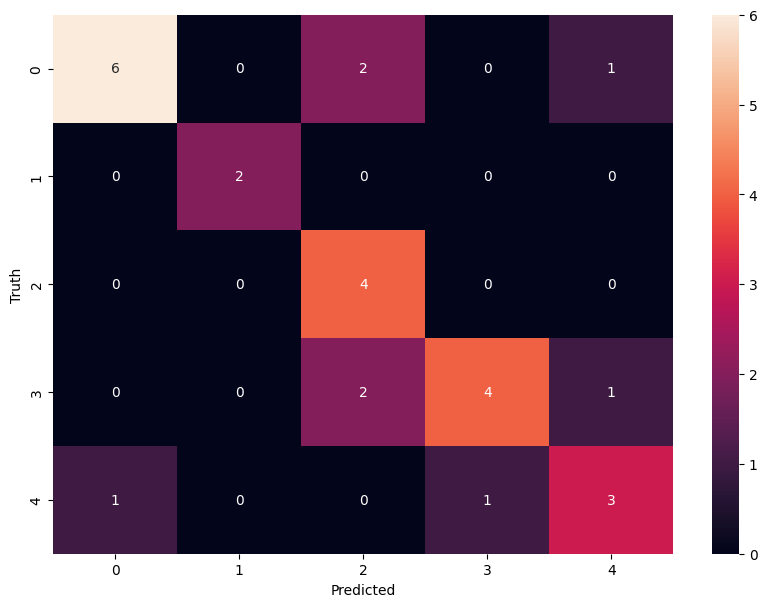

In [53]:
plt.figure(figsize = (10,7))
sn.heatmap(cm_2, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')